In [1]:
import geopandas as gpd
import censusdata
import pandas as pd
import os

# 1. Load ALL Texas census tracts
tracts = gpd.read_file("tl_2023_48_tract.shp")

# 2. Load all Texas places, select Fort Worth
places = gpd.read_file("tl_2023_48_place.shp")
fort_worth = places[places["NAME"] == "Fort Worth"].to_crs(tracts.crs)

# 3. Spatial join: select tracts intersecting the city boundary
tracts_in_fw = gpd.sjoin(tracts, fort_worth, predicate="intersects")
if 'index_right' in tracts_in_fw.columns:
    tracts_in_fw = tracts_in_fw.drop(columns='index_right')

# 4. Download median rent by bedroom for ALL Texas tracts (ACS 2023, Table B25031)
columns = [
    'B25031_001E',  # Median rent (all units)
    'B25031_002E',  # No bedroom
    'B25031_003E',  # 1 bedroom
    'B25031_004E',  # 2 bedrooms
    'B25031_005E',  # 3 bedrooms
    'B25031_006E',  # 4 bedrooms
    'B25031_007E',  # 5+ bedrooms
]
print("Downloading ACS 2023 median rent data by bedrooms (this takes a minute)...")
df = censusdata.download(
    'acs5', 2023,
    censusdata.censusgeo([('state', '48'), ('tract', '*')]),
    columns
)
df = df.reset_index()
df.rename(columns={'index': 'geo'}, inplace=True)
df['tract'] = df['geo'].apply(lambda g: g.geo[2][1])
df['county'] = df['geo'].apply(lambda g: g.geo[1][1])

# 5. Merge on BOTH TRACTCE and COUNTYFP (for uniqueness)
tracts_in_fw['TRACTCE'] = tracts_in_fw['TRACTCE'].astype(str)
tracts_in_fw['COUNTYFP'] = tracts_in_fw['COUNTYFP'].astype(str)
df['tract'] = df['tract'].astype(str)
df['county'] = df['county'].astype(str)

merged = tracts_in_fw.merge(df, left_on=['TRACTCE', 'COUNTYFP'], right_on=['tract', 'county'])

# 6. Add centroid coordinates
merged['lon'] = merged.geometry.centroid.x
merged['lat'] = merged.geometry.centroid.y

# 7. Keep/rename columns for output
output_gdf = merged.copy()
output_gdf.rename(columns={
    'B25031_001E': 'median_rent_all',
    'B25031_002E': 'median_rent_0br',
    'B25031_003E': 'median_rent_1br',
    'B25031_004E': 'median_rent_2br',
    'B25031_005E': 'median_rent_3br',
    'B25031_006E': 'median_rent_4br',
    'B25031_007E': 'median_rent_5pbr',
}, inplace=True)

output_cols = [
    'median_rent_all', 'median_rent_0br', 'median_rent_1br', 'median_rent_2br',
    'median_rent_3br', 'median_rent_4br', 'median_rent_5pbr',
    'lat', 'lon', 'geometry'
]
output_gdf = output_gdf[output_cols]

# 8. Save to GeoJSON
output_gdf.to_file("fort_worth_tracts_with_bedroom_rent.geojson", driver="GeoJSON")
print("Saved: fort_worth_tracts_with_bedroom_rent.geojson")



C:\Users\NegahdN\AppData\Local\Temp\ipykernel_17412\3990769682.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['lon'] = merged.geometry.centroid.x
C:\Users\NegahdN\AppData\Local\Temp\ipykernel_17412\3990769682.py:49: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['lat'] = merged.geometry.centroid.y


Saved: fort_worth_tracts_with_bedroom_rent.geojson


Generated 2268 grid pieces within Fort Worth tracts.


C:\Users\NegahdN\AppData\Local\Temp\ipykernel_17412\2240054567.py:43: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


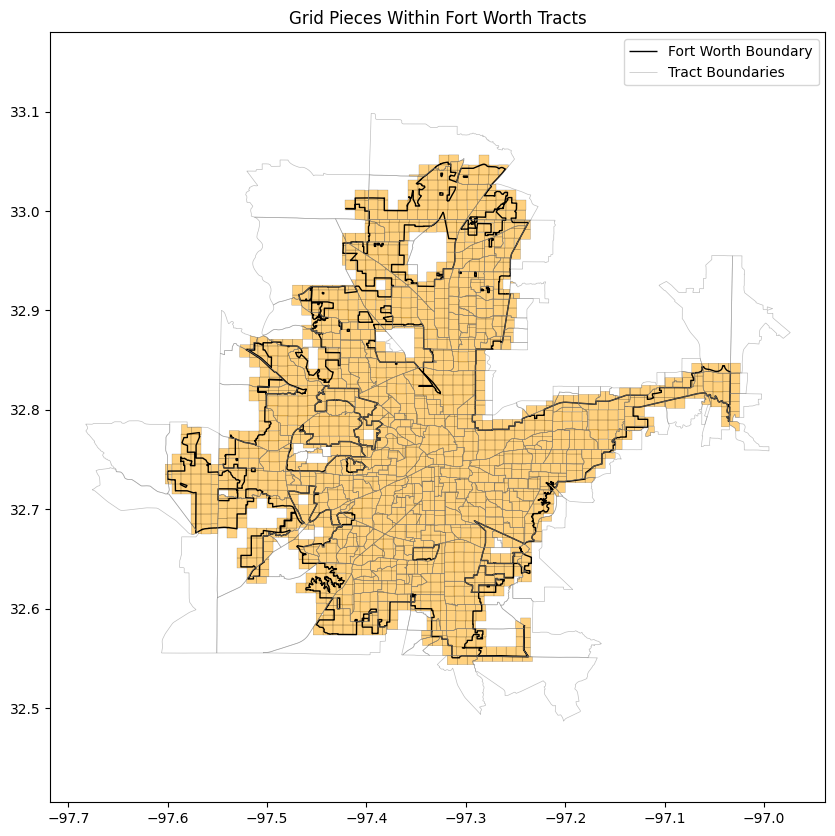

In [3]:
from shapely.geometry import box
import numpy as np
import matplotlib.pyplot as plt

# Divide each tract into smaller pieces (e.g., using a grid of points or polygons), then select only those pieces within the Fort Worth city boundary


# Set grid size (in degrees, e.g., ~0.01 is about 1km, adjust as needed)
grid_size = 0.01

# List to hold grid pieces within Fort Worth
grid_pieces = []

# Loop through each tract in Fort Worth
for idx, tract in tracts_in_fw.iterrows():
    bounds = tract.geometry.bounds  # (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy = bounds
    # Create grid cells within the tract's bounding box
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)
    for x in x_coords:
        for y in y_coords:
            cell = box(x, y, x + grid_size, y + grid_size)
            # Only keep cell if it intersects both the tract and the city boundary
            if tract.geometry.intersects(cell) and fort_worth.iloc[0].geometry.intersects(cell):
                # Optionally, clip the cell to the tract geometry
                clipped = cell.intersection(tract.geometry)
                if not clipped.is_empty:
                    grid_pieces.append({'tract': tract['TRACTCE'], 'geometry': clipped})

# Create GeoDataFrame of grid pieces within city boundary
grid_gdf = gpd.GeoDataFrame(grid_pieces, crs=tracts_in_fw.crs)

print(f"Generated {len(grid_gdf)} grid pieces within Fort Worth tracts.")
grid_gdf.head()
# Plot the generated grid pieces within Fort Worth tracts
fig, ax = plt.subplots(figsize=(10, 10))
fort_worth.boundary.plot(ax=ax, color='black', linewidth=1, label='Fort Worth Boundary')
tracts_in_fw.boundary.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5, label='Tract Boundaries')
grid_gdf.plot(ax=ax, color='orange', alpha=0.5, edgecolor='k', linewidth=0.2, label='Grid Pieces')
plt.title("Grid Pieces Within Fort Worth Tracts")
plt.axis('equal')
plt.legend()
plt.show()
# Save the grid pieces to a GeoJSON file
grid_gdf.to_file("fort_worth_grid_pieces.geojson", driver="GeoJSON")

Saved fort_worth_grid_pieces_bedrooms.geojson with rent info! Count: 2268


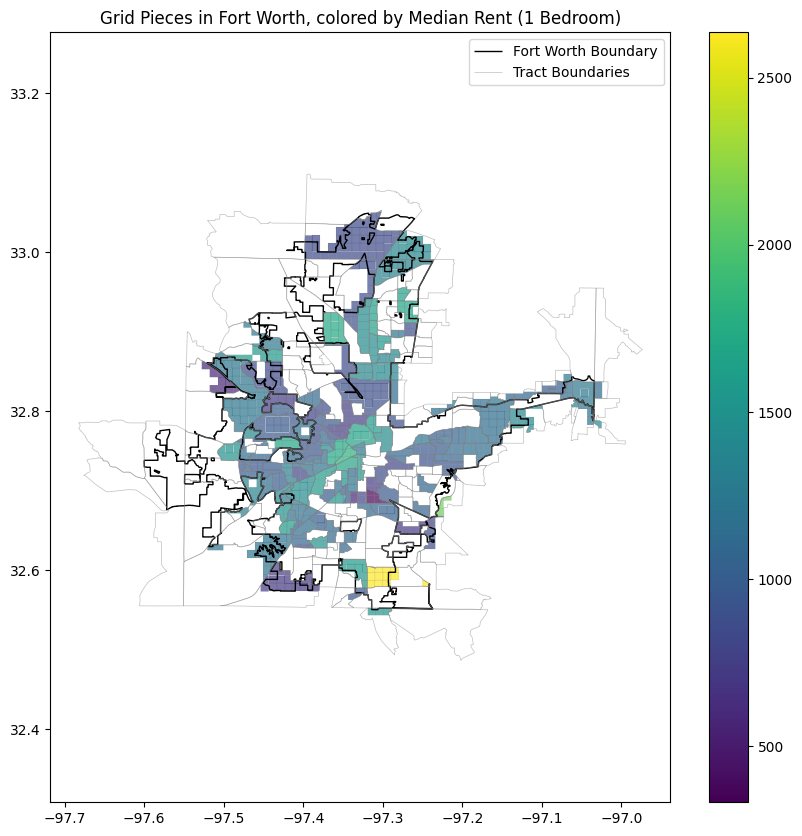

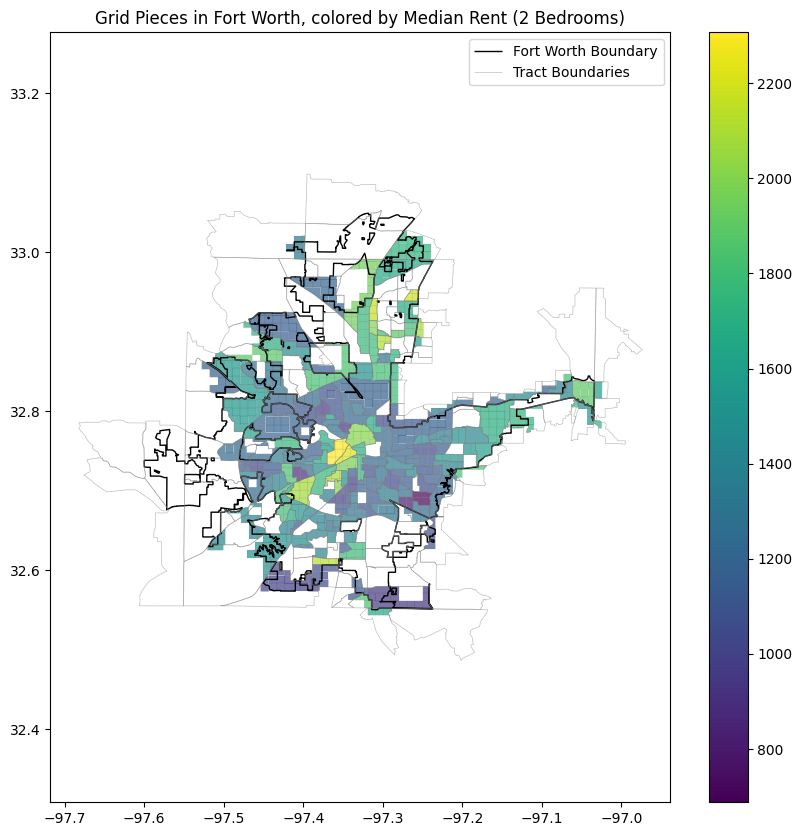

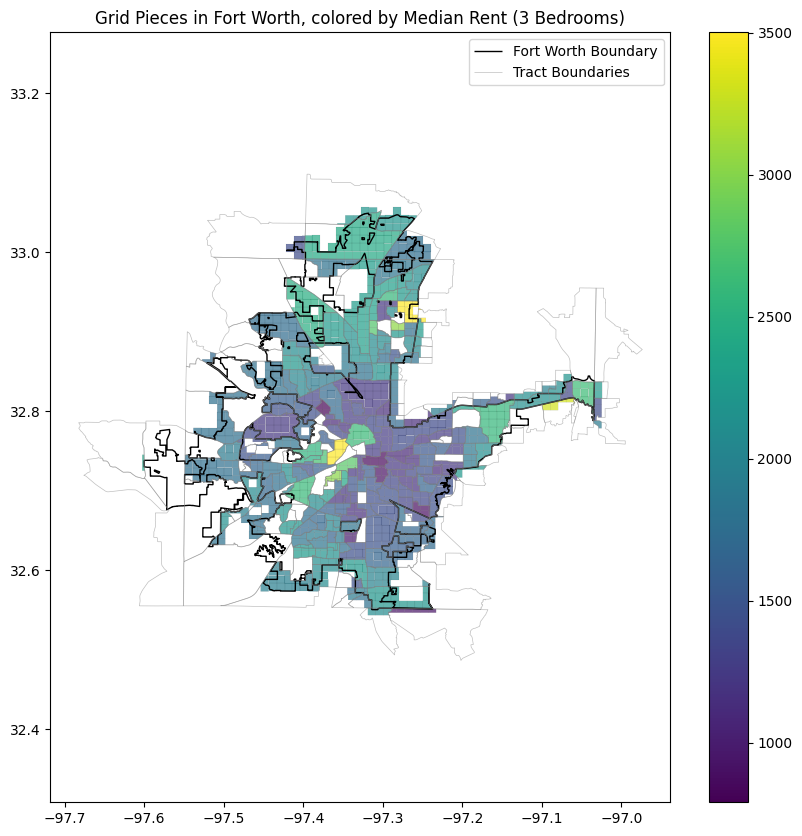

Saved: fort_worth_boundary.geojson
Saved: fort_worth_tract_boundaries.geojson


In [6]:
import geopandas as gpd
import censusdata
from shapely.geometry import box
import numpy as np
import matplotlib.pyplot as plt

# 1. Load ALL Texas census tracts
tracts = gpd.read_file("tl_2023_48_tract.shp")  # Statewide

# 2. Load all Texas places, select Fort Worth
places = gpd.read_file("tl_2023_48_place.shp")
fort_worth = places[places["NAME"] == "Fort Worth"].to_crs(tracts.crs)

# 3. Select tracts that intersect the city boundary
tracts_in_fw = gpd.sjoin(tracts, fort_worth, predicate="intersects")
if 'index_right' in tracts_in_fw.columns:
    tracts_in_fw = tracts_in_fw.drop(columns='index_right')

# 4. Download median rent by bedrooms (2023 ACS, Table B25031)
columns = [
    'B25031_001E',  # All units
    'B25031_002E',  # No bedroom
    'B25031_003E',  # 1 bedroom
    'B25031_004E',  # 2 bedrooms
    'B25031_005E',  # 3 bedrooms
    'B25031_006E',  # 4 bedrooms
    'B25031_007E',  # 5+ bedrooms
]
df = censusdata.download(
    'acs5', 2023,
    censusdata.censusgeo([('state', '48'), ('tract', '*')]),
    columns
)
df = df.reset_index()
df.rename(columns={'index': 'geo'}, inplace=True)
df['tract'] = df['geo'].apply(lambda g: g.geo[2][1])
df['county'] = df['geo'].apply(lambda g: g.geo[1][1])

# 5. Merge rent data onto Fort Worth tracts
tracts_in_fw['TRACTCE'] = tracts_in_fw['TRACTCE'].astype(str)
tracts_in_fw['COUNTYFP'] = tracts_in_fw['COUNTYFP'].astype(str)
df['tract'] = df['tract'].astype(str)
df['county'] = df['county'].astype(str)
tracts_in_fw = tracts_in_fw.merge(df, left_on=['TRACTCE', 'COUNTYFP'], right_on=['tract', 'county'], how='left')

# 6. Divide each tract into grid pieces (e.g., ~1km square)
grid_size = 0.01  # About 1km
grid_pieces = []

for idx, tract in tracts_in_fw.iterrows():
    bounds = tract.geometry.bounds
    minx, miny, maxx, maxy = bounds
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)
    for x in x_coords:
        for y in y_coords:
            cell = box(x, y, x + grid_size, y + grid_size)
            # Only keep if it intersects both tract and city boundary
            if tract.geometry.intersects(cell) and fort_worth.iloc[0].geometry.intersects(cell):
                clipped = cell.intersection(tract.geometry)
                if not clipped.is_empty:
                    # Add the tract's rent by bedrooms to each grid piece
                    grid_pieces.append({
                        'tract': tract['TRACTCE'],
                        'county': tract['COUNTYFP'],
                        'median_rent_all': tract['B25031_001E'],
                        'median_rent_0br': tract['B25031_002E'],
                        'median_rent_1br': tract['B25031_003E'],
                        'median_rent_2br': tract['B25031_004E'],
                        'median_rent_3br': tract['B25031_005E'],
                        'median_rent_4br': tract['B25031_006E'],
                        'median_rent_5pbr': tract['B25031_007E'],
                        'geometry': clipped
                    })

# 7. Create GeoDataFrame of grid pieces WITH all rent columns
grid_gdf = gpd.GeoDataFrame(grid_pieces, crs=tracts_in_fw.crs)

# 8. Save to GeoJSON with rent info!
grid_gdf.to_file("fort_worth_grid_pieces_bedrooms.geojson", driver="GeoJSON")
print(f"Saved fort_worth_grid_pieces_bedrooms.geojson with rent info! Count: {len(grid_gdf)}")

# 9. (Optional) Plot for a selected bedroom count, e.g., 2 bedrooms
for bedroom_col, label in [
    ('median_rent_1br', '1 Bedroom'),
    ('median_rent_2br', '2 Bedrooms'),
    ('median_rent_3br', '3 Bedrooms')
]:
    valid_grid_gdf = grid_gdf[grid_gdf[bedroom_col] > 0]
    fig, ax = plt.subplots(figsize=(10, 10))
    fort_worth.boundary.plot(ax=ax, color='black', linewidth=1, label='Fort Worth Boundary')
    tracts_in_fw.boundary.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5, label='Tract Boundaries')
    valid_grid_gdf.plot(ax=ax, column=bedroom_col, cmap='viridis', alpha=0.7, edgecolor='k', linewidth=0.05, legend=True)
    plt.title(f"Grid Pieces in Fort Worth, colored by Median Rent ({label})")
    plt.axis('equal')
    plt.legend()
    plt.show()

# 10. Save boundaries if needed
fort_worth.boundary.to_file("fort_worth_boundary.geojson", driver="GeoJSON")
print("Saved: fort_worth_boundary.geojson")
tracts_in_fw.boundary.to_file("fort_worth_tract_boundaries.geojson", driver="GeoJSON")
print("Saved: fort_worth_tract_boundaries.geojson")
